# Getting Started with Spectral Clustering

In this notebook I want to explore the ideas behind [spectral clustering](https://en.wikipedia.org/wiki/Spectral_clustering). I do not intend to develop the theory. Instead, I will unravel a practical example to illustrate and motivate the intuition behind each step of the spectral clustering algorithm. I particularly recommend two references: 

- For an introduction/overview on the theory, see the lecture notes [A Tutorial on Spectral Clustering](http://www.tml.cs.uni-tuebingen.de/team/luxburg/publications/Luxburg07_tutorial.pdf) by [Prof. Dr. Ulrike von Luxburg](http://www.tml.cs.uni-tuebingen.de/team/luxburg/index.php). 
- For a concrete application of this clustering method you can see the PyData's talk: [Extracting relevant Metrics with Spectral Clustering](https://www.youtube.com/watch?v=3heWpR6dC8k) by Dr. Evelyn Trautmann.

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%config InlineBackend.figure_format = 'png'

## Generate Sample Data

Let us generate some sample data. As we will see, spectral clustering is very effective for non-convex clusters. In this example, we consider concentric circles:

In [2]:
# Set random state. 
rs = np.random.seed(25)

def generate_circle_sample_data(r, n, sigma):
    """Generate circle data with random gaussian noise."""
    angles = np.random.uniform(low=0, high=2*np.pi, size=n)

    x_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)
    y_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)

    x = r*np.cos(angles) + x_epsilon
    y = r*np.sin(angles) + y_epsilon
    
    return x, y


def generate_concentric_circles_data(param_list):
    """Generates many circle data with random gaussian noise."""
    coordinates = [ 
        generate_circle_sample_data(param[0], param[1], param[2])
     for param in param_list
    ]

    return coordinates

Let us plot some examples to see how the parameters affect the data structure and clusters. 

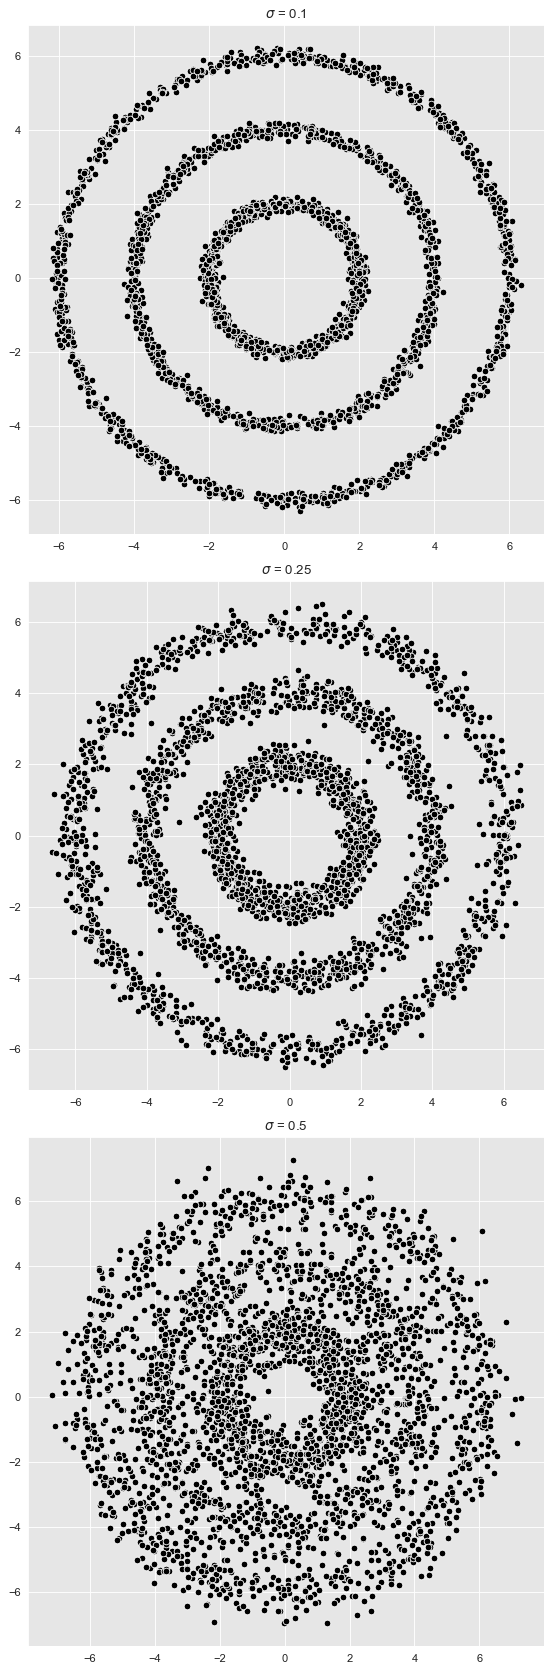

In [3]:
# Set global plot parameters. 
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 80

# Number of points per circle. 
n = 1000
# Radius. 
r_list =[2, 4, 6]
# Standar deviation (gaussian noise). 
sigmas = [0.1, 0.25, 0.5]

param_lists = [[(r, n, sigma) for r in r_list] for sigma in sigmas] 
# We store the data on this list.
coordinates_list = []

fig, axes = plt.subplots(3, 1, figsize=(7, 21))

for i, param_list in enumerate(param_lists):

    coordinates = generate_concentric_circles_data(param_list)

    coordinates_list.append(coordinates)
    
    ax = axes[i]
    
    for j in range(0, len(coordinates)):
    
        x, y = coordinates[j]
        sns.scatterplot(x=x, y=y, color='black', ax=ax)
        ax.set(title=f'$\sigma$ = {param_list[0][2]}')

plt.tight_layout()

The first two plots show $3$ clear clusters. For the last one the cluster structure is less clear. 

## Spectral Clustering Algorithm

Even though we are not going to give all the theoretical details, we are still going to motivate the logic behind the spectral clustering algorithm. 

### The Graph Laplacian

One of the key concepts of spectral clustering is the [graph Laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix). Let us describe its construction^[Laplacian Eigenmaps for Dimensionality Reduction and Data Representation](http://web.cse.ohio-state.edu/~belkin.8/papers/LEM_NC_03.pdf):

- Let us assume we are given a data set of points $X:=\{x_1, \cdots, x_n\}\subset \mathbb{R}^{m}$. 
- To this data set $X$ we associate a (weighted) graph $G$ which encodes how close the data points are. Concretely, 
    - The nodes of $G$ are given by each data point $x_i\in\mathbb{R}^{m}$.
    - Two nodes $x_{i}$ and $x_{j}$ are connected by an edge if they are *close*. The notion of *closeness* depends on the distance we want to encode. There are two common choices. 
        - (Euclidean Distance) Given $\varepsilon >0$, $x_i$ and $x_j$ are joint by and edge if $||x_i - x_j||< \varepsilon$. For some applications an edge might have a weight of the form $e^{-||x_i - x_j||^2}$.
        - (Nearest Neighbors) $x_i$ and $x_j$ are joint by and edge if $x_j$ is a $k$-nearest neighbor of $x_j$. 

Once the graph is constructed we can consider its associated [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) $W \in M_{n}(\mathbb{R})$ which has a non-zero value in the $W_{ij}$ entry if $x_i$ and $x_j$ are connected by an edge. On the other hand, let $D\in M_{n}(\mathbb{R})$ denote [degree matrix](https://en.wikipedia.org/wiki/Degree_matrix) of the graph, which is the diagonal matrix containing the degrees of each node. Then the graph Laplacian $L \in M_{n}(\mathbb{R})$ is defined as the difference  $L:= D - W \in M_{n}(\mathbb{R})$. This matrix is a symmetric and positive semi-definite, which implies (by the [spectral theorem](https://juanitorduz.github.io/the-spectral-theorem-for-matrices/)) that all its eigenvalues are real and non-negative. [Here](https://juanitorduz.github.io/documents/orduz_pydata2018.pdf) you can find more details on the graph Laplacian's definition and properties. 


### The Motivation 

Why is the graph Laplacian relevant for detecting clusters? Let us start with an easy case on which the data $X$ has two clusters $X_1, X_2$ so spread apart that they correspond to the [connected components](https://en.wikipedia.org/wiki/Component_(graph_theory)) $G_1, $G_2$ of the associated graph $G=G_1\cup G_2$. Observe, from the pure definition of the graph Laplacian , that we can reorder the points in such a way that the graph Laplacian decomposes as 

$$
L_G = 
\left(
\begin{array}{cc}
L_{G_1} & 0 \\
0 & L_{G_22}
\end{array}
\right)
$$

where $L_{G_1}$ and $L_{G_2}$ are the graph Laplacians of $G_1$ and $G_2$ respectively. One can show that the kernel (eigenspace of the zero eigenvalue) has dimension $2$ and it is generated by the pair of orthogonal eigenvectors $(1, 1, \cdots, 0, 0)$  and $(0, 0, \cdots, 1, 1)$. This argument is easy to generalize for many connected components. In summary, the key property is that the number of connected components of the assocated graph can be obtained by calculating the dimension of the kernel of the corresponding graph Laplacian. 

What if the associated graph of the data set is connected but we still want to detect clusters? Well, the argument above remains stable (in certain sense) under small perturbations and one can detect clusters by running k-means on the rows of the matrix of eigenvectors of the small eigenvalues of the graph Laplacian. Again, please refer to the lecture notes suggested above to get the details. 

### Tha Algoritm 

Here are the steps for the (unnormalized) spectral clustering^[A Tutorial on Spectral Clustering](http://www.tml.cs.uni-tuebingen.de/team/luxburg/publications/Luxburg07_tutorial.pdf). The step should now sound reasonable based on the discussion above. 

*Input:* Similarity matrix $S\in M_{n}(\mathbb{R})$ (choice of distance), number $k$ of clusters to construct.

*Steps:*
- Let $W$ be the (weighted) adjacency matrix of the corresponding graph.
- Compute the (unnormalized) Laplacian $L$.
- Compute the first $k$ eigenvectors $u_1, \cdots, u_k$ of $L$.
- Let $U \in M_{n×k}$ be the matrix containing the vectors $u_1, \cdots, u_k$ as columns.
- For $i = 1, \cdots, n$ let $y_i\in \mathbb{R}^k$ be the vector corresponding to the $i$-th row of $U$.
- Cluster the points $y_i\in \mathbb{R}^k$ with the $k$-means algorithm into clusters $C_1, \cdots, C_k$

*Output:* Clusters $A_1, \cdots, A_k$ with $A_i = \{j\:|\: y_j ∈ C_i\}$.

Let us reproduce these steps on an example to get a better feeling on why this algorithm works.

---
The main idea is that, given a data set, we can encode its structure on a graph and then use the fact (which we will show below) that the number of connected components of the resulting graph is determined by the multiplicity of the zero eigenvalue of the [graph laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix). That is, if in the graph representation of the data set has different connected components (clusters) these can be detected by the spectrum of the graph Laplacian. Requiring clusters to be just connected components can be very restrictive, nevertheless by certain stability properties of the spectrum [A Tutorial on Spectral Clustering](http://www.tml.cs.uni-tuebingen.de/team/luxburg/publications/Luxburg07_tutorial.pdf), one can still get good clustering results even if the graph representation of the data set is connected.  

## Example 1: Well-defined Clusters

We consider sample data with the parameters defined above with `sigma` = 0.1. Note from the plots above that in this case the clusters separate well. 

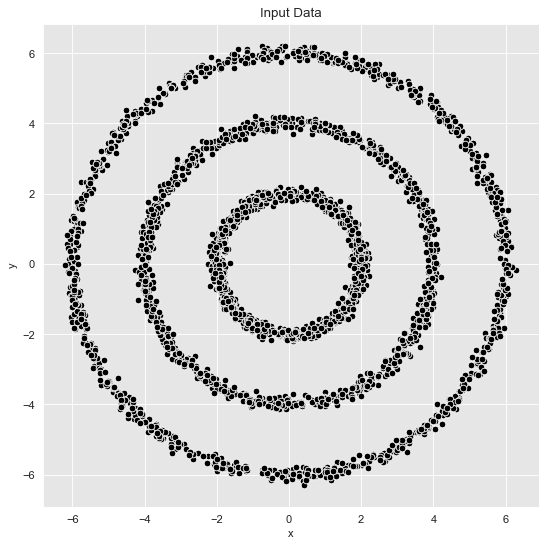

In [4]:
from itertools import chain

coordinates = coordinates_list[0]

def data_frame_from_coordinates(coordinates): 
    """From coordinates to data frame."""
    xs = chain(*[c[0] for c in coordinates])
    ys = chain(*[c[1] for c in coordinates])

    return pd.DataFrame(data={'x': xs, 'y': ys})

data_df = data_frame_from_coordinates(coordinates)

# Plot the input data.
fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', color='black', data=data_df, ax=ax)
ax.set(title='Input Data');

### K - Means

Let us begin by running a k-means algorithm to try to get some clusters. We select the number of cluster using the elbow method by considering the inertia (sum of squared distances of samples to their closest cluster center) as a function of the number of clusters.

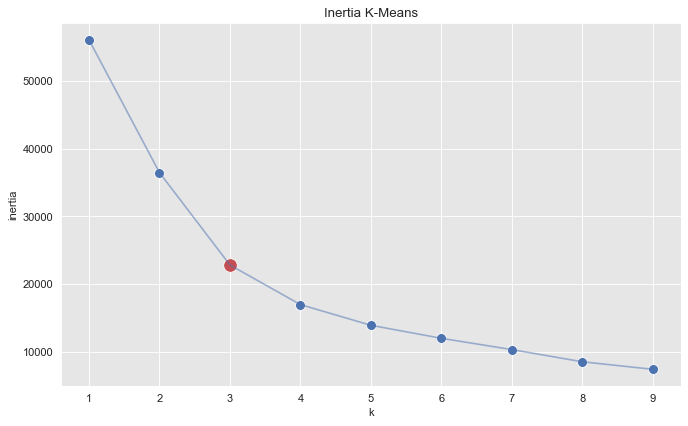

In [5]:
from sklearn.cluster import KMeans

inertias = []

k_candidates = range(1, 10)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(data_df)
    inertias.append(k_means.inertia_)

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.scatterplot(x=[k_candidates[2]], y = [inertias[2]], color=sns_c[3], s=150, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

From this plot we see that $k=3$ is a good choice. Let us get the clusters.

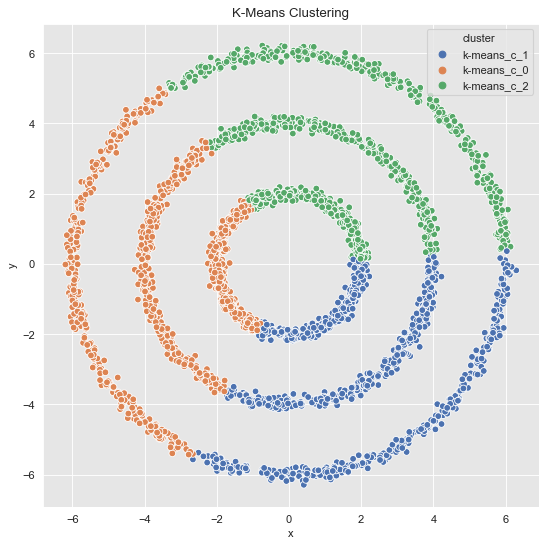

In [6]:
k_means = KMeans(random_state=25, n_clusters=3)
k_means.fit(data_df)
cluster = k_means.predict(data_df)

cluster = ['k-means_c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df.assign(cluster = cluster), hue='cluster', ax=ax)
ax.set(title='K-Means Clustering');

The result is not very surprising since $k$-means generates convex clusters. 

### Step 1: Compute Graph Laplacian

In this first step we compute the graph Laplacian. We are going to use nearest neighbors to generate the graph to model our data set. 

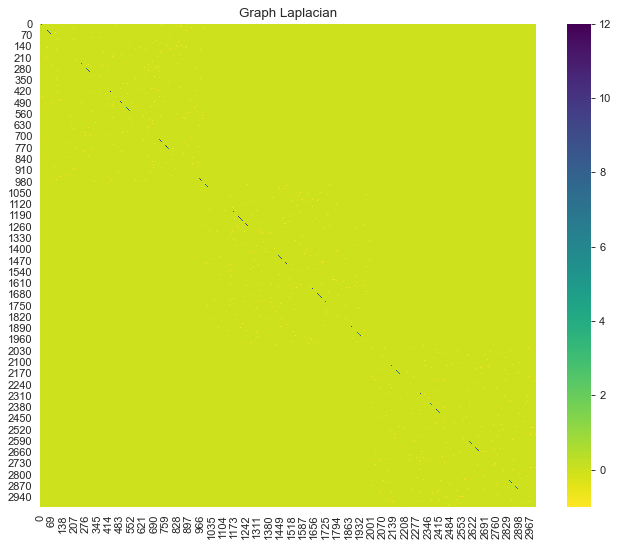

In [7]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=data_df, nn=8)

# Plot the graph Laplacian as heat map.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');

### Step 2: Compute Spectrum of the Graph Laplacian

Next, we compute the eigenvalues and eigenvectors of the graph Laplacian. 

In [8]:
from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)

The eigenvalues are represented by complex numbers. Since the graph Laplacian is a symmetric matrix, we know by the [spectral theorem](https://juanitorduz.github.io/the-spectral-theorem-for-matrices/) that all the eigenvalues must be real. Let us verify this:

In [9]:
np.unique(np.imag(eigenvals))

array([0.])

In [10]:
# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

We now compute the $L^2$-norms of the eigenvectors.

In [11]:
eigenvcts_norms = np.apply_along_axis(lambda v: np.linalg.norm(v, ord=2), axis=0, arr=eigenvcts)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 0.9999999999999997
Max Norm: 1.0000000000000002


Hence, all of the eigenvectors have length ~ 1.

We then sort the eigenvalues in ascending order.

In [12]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

Let us plot the sorted eigenvalues. 

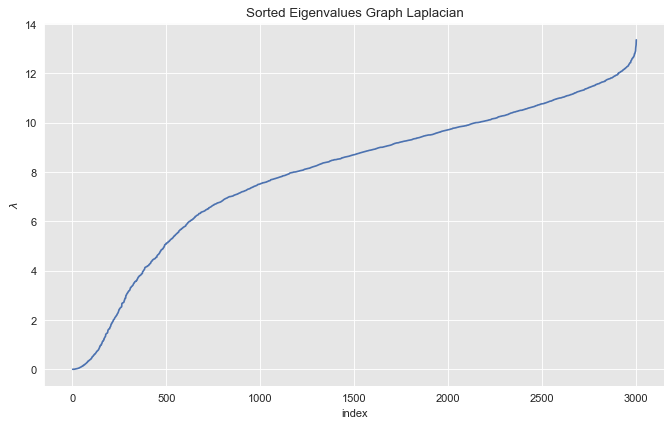

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

### Step 3: Find the Small Eigenvalues 

Let us zoom in into small eigenvalues.

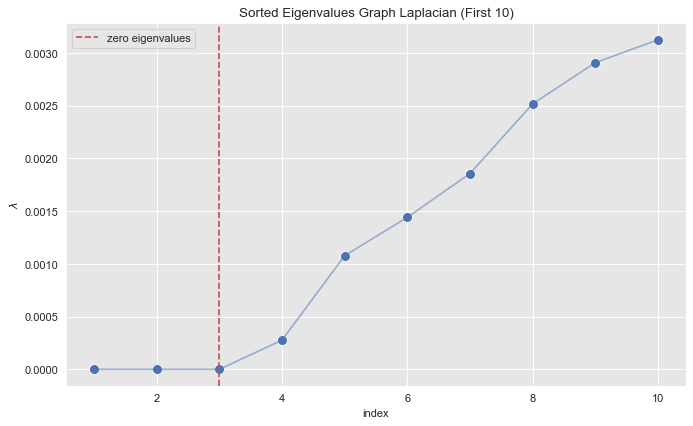

In [14]:
index_lim = 10

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

From the plot we see see that the first $3$ eigenvalues (sorted) are essentially zero.

In [15]:
zero_eigenvals_index = np.argwhere(abs(eigenvals) < 1e-5)
eigenvals[zero_eigenvals_index]

array([[-9.42076177e-16],
       [ 8.21825247e-16],
       [ 5.97249344e-16]])

For these small eigenvalues, we consider their corresponding eigenvectors.

In [16]:
proj_df = pd.DataFrame(eigenvcts[:, zero_eigenvals_index.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
proj_df.head()

,v_0,v_1,v_2
0,0.031623,0.0,0.0
1,0.031623,0.0,0.0
2,0.031623,0.0,0.0
3,0.031623,0.0,0.0
4,0.031623,0.0,0.0


Let us visualize this data frame as a heat map:

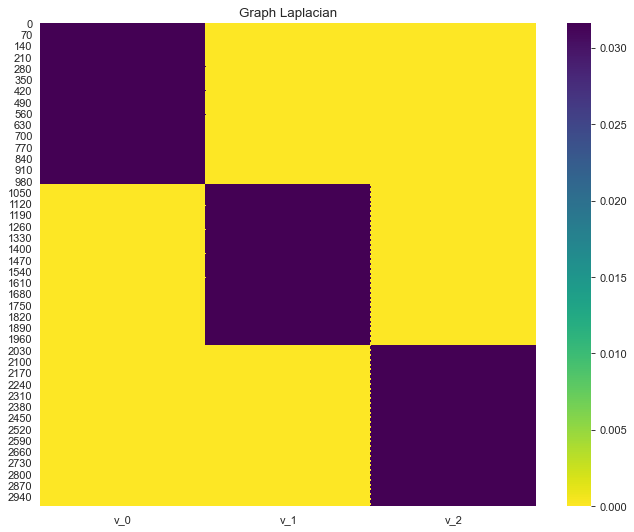

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(proj_df, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');

We can clearly see a block structure (representing the connected components). In general, finding zero eigenvalues, or the spectral gap happens, is to restrictive when the clusters are not isolated connected components. Hence, we simply choose the number of clusters we want to find. 

In [18]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first 
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

### Step 4: Run K-Means Clustering

To select the number of clusters (which from the plot above we already suspect is $k=3$) we run k-means for various cluster values and plot the associated inertia (sum of squared distances of samples to their closest cluster center).

In [19]:
inertias = []

k_candidates = range(1, 6)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)

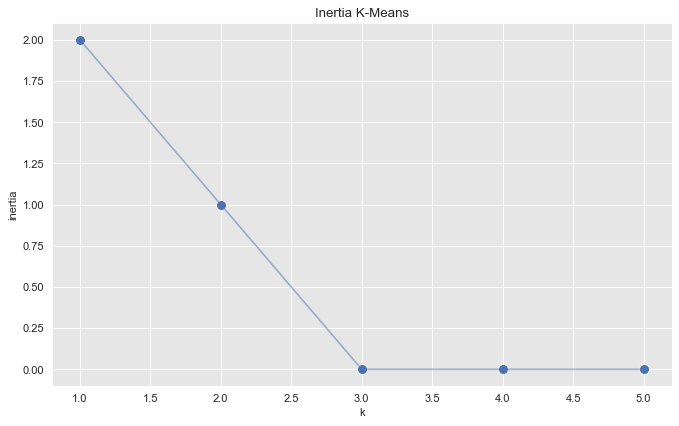

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

From this plot we see that the optomal number of clusters is $k=3$.

In [21]:
def run_k_means(df, n_clusters):
    """K-means clustering."""
    k_means = KMeans(random_state=25, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster

cluster = run_k_means(proj_df, n_clusters=3)

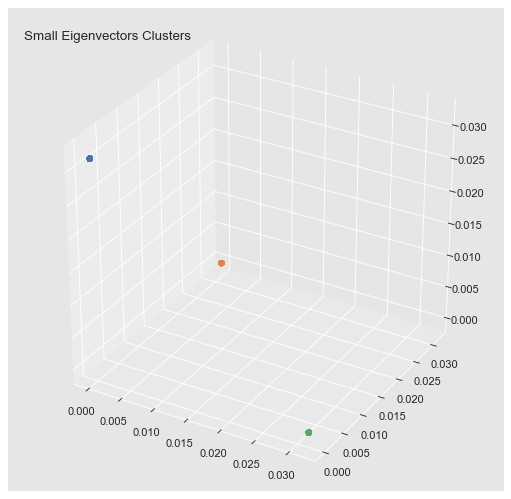

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=proj_df['v_0'], 
    ys=proj_df['v_1'], 
    zs=proj_df['v_2'],
    c=[{0: sns_c[0], 1: sns_c[1], 2: sns_c[2]}.get(c) for c in cluster]
)
ax.set_title('Small Eigenvectors Clusters', x=0.2);

### Step 5: Assing Cluster Tag

Finally we add the cluster tag to each point.

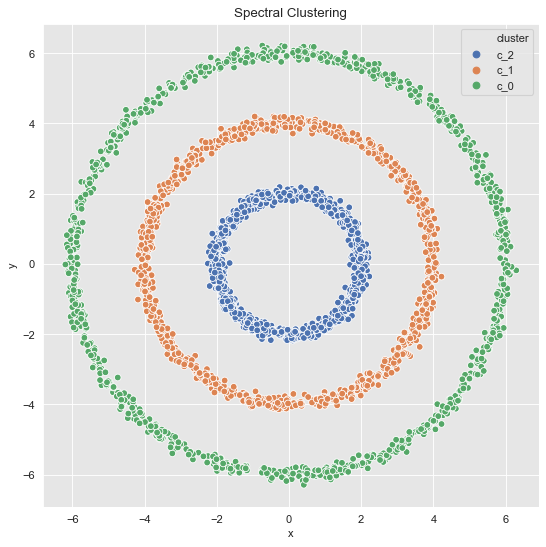

In [23]:
data_df['cluster'] = ['c_' + str(c) for c in cluster]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

Note that via spectral clustering we can get non-convex clusters. 

### Summary 

To wrap up the algorithm steps we summarize them in a function.

In [24]:
def spectral_clustering(df, n_neighbors, n_clusters):
    """Spectral Clustering Algorithm."""
    graph_laplacian = generate_graph_laplacian(df, n_neighbors)
    eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)
    proj_df = project_and_transpose(eigenvals, eigenvcts, n_clusters)
    cluster = run_k_means(proj_df, proj_df.columns.size)
    return ['c_' + str(c) for c in cluster]

## Example 2

Let us consider the data which has more noise:

- 3 Clusters

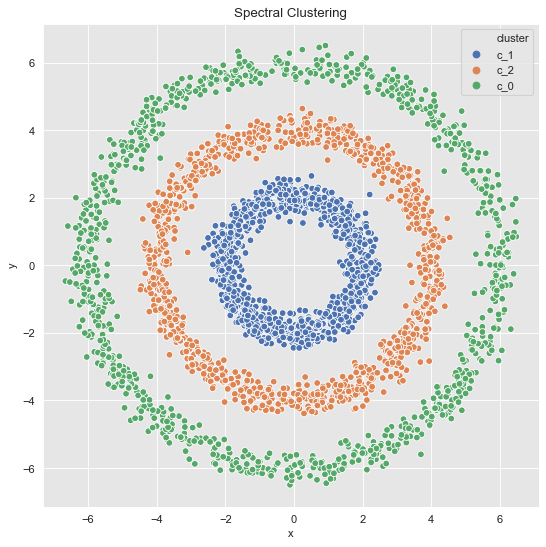

In [25]:
data_df = data_frame_from_coordinates(coordinates_list[1])
data_df['cluster'] = spectral_clustering(df=data_df, n_neighbors=8, n_clusters=3)

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

- 2 Clusters

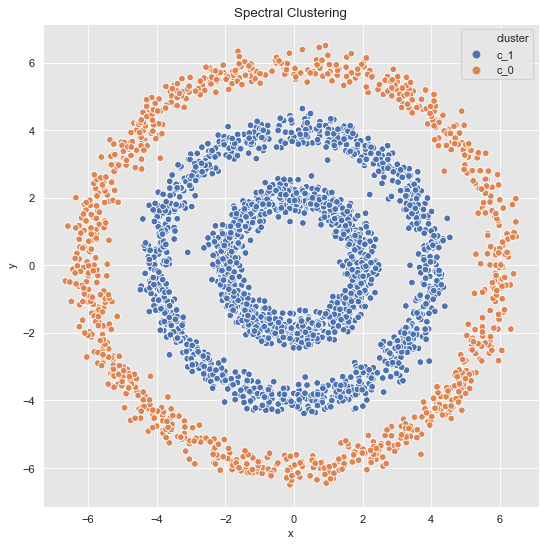

In [26]:
data_df = data_frame_from_coordinates(coordinates_list[1])
data_df['cluster'] = spectral_clustering(df=data_df, n_neighbors=8, n_clusters=2)

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

## Example 3

For the last data set, we essentially find the same as we would with k-means. 

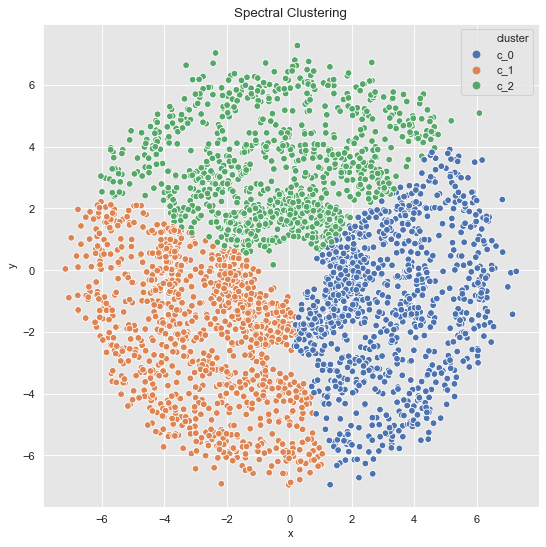

In [27]:
data_df = data_frame_from_coordinates(coordinates_list[2])
data_df['cluster'] = spectral_clustering(df=data_df, n_neighbors=8, n_clusters=3)

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering');

## SpectralClustering (Scikit-Learn)

As expected, [scikit-learn](https://scikit-learn.org/stable/) already has a [spectral clustering implementation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html). Let us compare with the results above.

### Example 2 (Revisited)

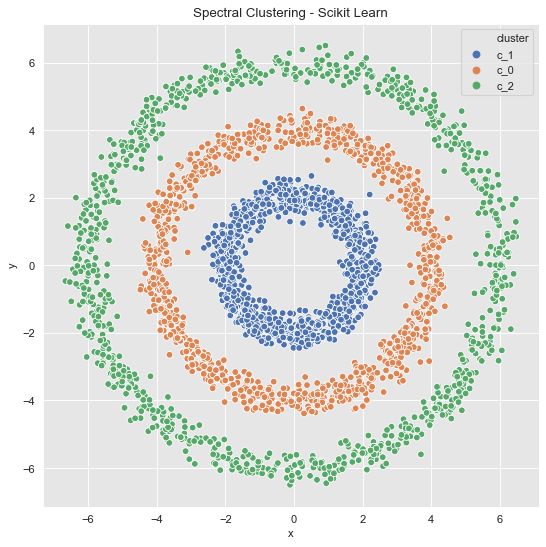

In [28]:
from sklearn.cluster import SpectralClustering

data_df = data_frame_from_coordinates(coordinates_list[1])

spec_cl = SpectralClustering(
    n_clusters=3, 
    random_state=25, 
    n_neighbors=8, 
    affinity='nearest_neighbors'
)

data_df['cluster'] = spec_cl.fit_predict(data_df[['x', 'y']])
data_df['cluster'] = ['c_' + str(c) for c in data_df['cluster']]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering - Scikit Learn');

### Example 3 (Revisited)

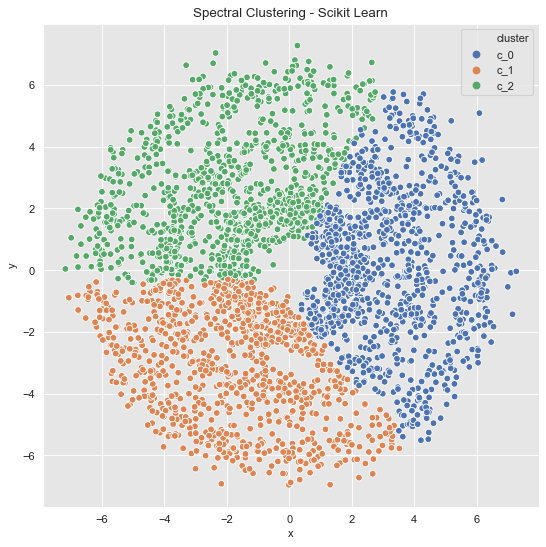

In [29]:
data_df = data_frame_from_coordinates(coordinates_list[2])

spec_cl = SpectralClustering(
    n_clusters=3, 
    random_state=42, 
    n_neighbors=8, 
    affinity='nearest_neighbors'
)

data_df['cluster'] = spec_cl.fit_predict(data_df[['x', 'y']])
data_df['cluster'] = ['c_' + str(c) for c in data_df['cluster']]

fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data_df, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering - Scikit Learn');

## Final Remark 

In concrete applications is sometimes hard to evaluate which clustering algorithm to choose. I often prefer to do some feature engineering (from intuition/domain knowledge) and proceed, if possible, with k-means. For the example above we see a rotationally symmetric data set, which suggest to use the radius as a new feature:

In [30]:
data_df = data_frame_from_coordinates(coordinates_list[1])

data_df = data_df.assign(r2 = lambda x: np.power(x['x'], 2) + np.power(x['y'], 2))

Let us plot the radius feature (it is one-dimensional but we project it to the (diagonal) line $x=y$). 

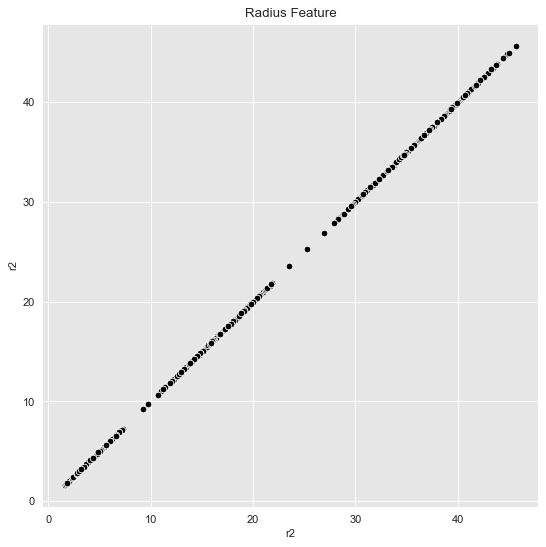

In [31]:
fig, ax = plt.subplots()
sns.scatterplot(x='r2', y='r2', color='black', data=data_df, ax=ax)
ax.set(title='Radius Feature');

Then, we can just run k-means.

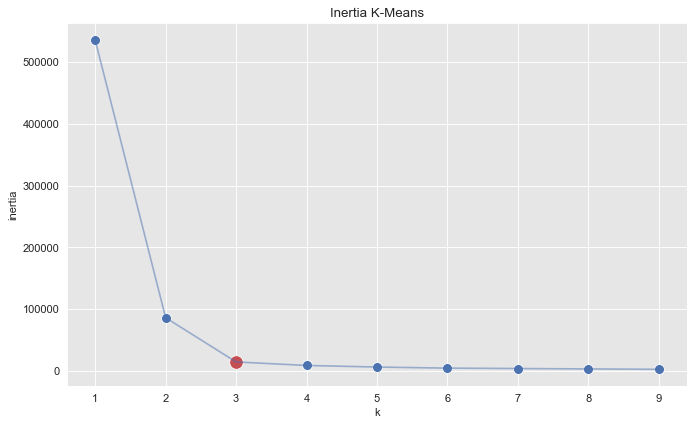

In [32]:
inertias = []

k_candidates = range(1, 10)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(data_df[['r2']])
    inertias.append(k_means.inertia_)

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
sns.scatterplot(x=[k_candidates[2]], y = [inertias[2]], color=sns_c[3], s=150, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

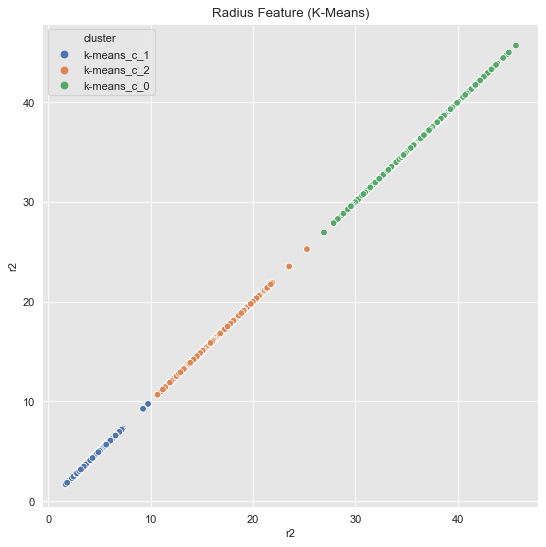

In [33]:
k_means = KMeans(random_state=25, n_clusters=3)
k_means.fit(data_df[['r2']])
cluster = k_means.predict(data_df[['r2']])

data_df = data_df.assign(cluster = ['k-means_c_' + str(c) for c in cluster])

fig, ax = plt.subplots()
sns.scatterplot(x='r2', y='r2', hue='cluster', data=data_df, ax=ax)
ax.set(title='Radius Feature (K-Means)');

Finally, we visualize the original data with the corresponding clusters. 

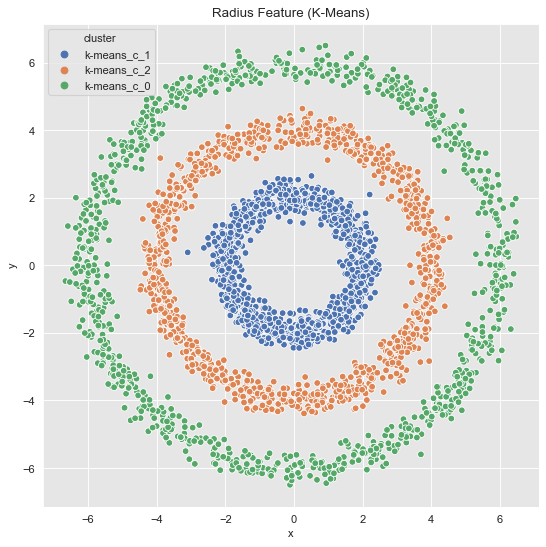

In [34]:
fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', hue='cluster', data=data_df, ax=ax)
ax.set(title='Radius Feature (K-Means)');